<a href="https://colab.research.google.com/github/namanphy/EVA5/blob/main/S9/main_S9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up code

#### Cloning the required [repository](https://github.com/namanphy/EVA5/) and adding the path to the code directory.

In [ ]:
import sys

! git clone https://github.com/namanphy/EVA5.git
! pip install git+https://github.com/albumentations-team/albumentations.git
sys.path.append('EVA5/S9/')

#### Importing the required modules and files

In [2]:
import cuda
from data.dataset import CIFAR10
from data.dataloader import data_loader
from model.model import ResNet18, model_summary
from model.functions import sgd_optimizer, cross_entropy_loss
from model.trainer import Trainer
from utils import set_seed, plot_metric, identify_misclassification, plot_results
from gradcam.gradcam import plot_gradcam

In [3]:
set_seed(123)
use_cuda = cuda.cuda_is_available()
device = cuda.enable_cuda()

## Making the data ready

In [4]:
cifar10 = CIFAR10(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), rotation=6, horizontal_flip=0.5, cutout=0.5, cutout_hw_ratio=2)

train_set = cifar10.download('../data', train=True, apply_transform=True)
test_set = cifar10.download('../data', train=False, apply_transform=True)

# Loading the datasets into Pytorch Dataloaders
train_loader = data_loader(train_set, 64, use_cuda, num_workers=4)
test_loader = data_loader(test_set, 64, use_cuda, num_workers=4)

Extracting ../data/cifar-10-python.tar.gz to ../data
Transforms :  {'train': True, 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'rotation': 6, 'horizontal_flip': 0.5, 'cutout': 0.5, 'cutout_height': 16, 'cutout_width': 16}
Files already downloaded and verified
Transforms :  {'train': False, 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'rotation': 6, 'horizontal_flip': 0.5, 'cutout': 0.5, 'cutout_height': 16, 'cutout_width': 16}
Files already downloaded and verified


#### Printing the shape of one image

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print('shape of one image - ', images[0].shape)

shape of one image -  torch.Size([3, 32, 32])


## Import model architecture and set up training

#### model setup

In [6]:
model = ResNet18()
model.name = 'ResNet18' # Giving my model a name
model_summary(model.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

#### Training model

In [7]:
results = {}  # empty dict to store results

criterion = cross_entropy_loss()
optimizer = sgd_optimizer(model, lr=0.01, l2_factor=0)

trainer = Trainer(model, optimizer, criterion, train_loader, valid_data_loader=test_loader, lr_scheduler=None, l1_loss=False)

results['resnet18'] = trainer.train(25)
trainer.save('cifar10_model')

  0%|          | 0/782 [00:00<?, ?it/s]

------------ EPOCH 1 -------------


Loss=1.233513355255127 Batch_id=781 Accuracy=45.17: 100%|██████████| 782/782 [00:31<00:00, 24.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1283, Accuracy: 6018/10000 (60%)

------------ EPOCH 2 -------------


Loss=0.8292896747589111 Batch_id=781 Accuracy=61.84: 100%|██████████| 782/782 [00:31<00:00, 24.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8922, Accuracy: 6899/10000 (69%)

------------ EPOCH 3 -------------


Loss=1.394466519355774 Batch_id=781 Accuracy=68.88: 100%|██████████| 782/782 [00:31<00:00, 25.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8309, Accuracy: 7211/10000 (72%)

------------ EPOCH 4 -------------


Loss=0.3348552882671356 Batch_id=781 Accuracy=72.94: 100%|██████████| 782/782 [00:31<00:00, 24.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6009, Accuracy: 7980/10000 (80%)

------------ EPOCH 5 -------------


Loss=0.51551753282547 Batch_id=781 Accuracy=75.46: 100%|██████████| 782/782 [00:31<00:00, 24.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5737, Accuracy: 8071/10000 (81%)

------------ EPOCH 6 -------------


Loss=1.0630226135253906 Batch_id=781 Accuracy=77.56: 100%|██████████| 782/782 [00:31<00:00, 24.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6057, Accuracy: 7898/10000 (79%)

------------ EPOCH 7 -------------


Loss=0.54757159948349 Batch_id=781 Accuracy=79.59: 100%|██████████| 782/782 [00:31<00:00, 24.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5322, Accuracy: 8226/10000 (82%)

------------ EPOCH 8 -------------


Loss=0.3759770095348358 Batch_id=781 Accuracy=81.10: 100%|██████████| 782/782 [00:31<00:00, 25.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5250, Accuracy: 8244/10000 (82%)

------------ EPOCH 9 -------------


Loss=1.0225160121917725 Batch_id=781 Accuracy=82.07: 100%|██████████| 782/782 [00:31<00:00, 25.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5146, Accuracy: 8292/10000 (83%)

------------ EPOCH 10 -------------


Loss=0.8895649909973145 Batch_id=781 Accuracy=83.29: 100%|██████████| 782/782 [00:31<00:00, 25.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4824, Accuracy: 8437/10000 (84%)

------------ EPOCH 11 -------------


Loss=0.617466151714325 Batch_id=781 Accuracy=84.18: 100%|██████████| 782/782 [00:31<00:00, 24.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4383, Accuracy: 8593/10000 (86%)

------------ EPOCH 12 -------------


Loss=0.3307400643825531 Batch_id=781 Accuracy=84.94: 100%|██████████| 782/782 [00:31<00:00, 24.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3991, Accuracy: 8670/10000 (87%)

------------ EPOCH 13 -------------


Loss=0.5214370489120483 Batch_id=781 Accuracy=86.04: 100%|██████████| 782/782 [00:31<00:00, 24.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4287, Accuracy: 8629/10000 (86%)

------------ EPOCH 14 -------------


Loss=0.1925206482410431 Batch_id=781 Accuracy=86.85: 100%|██████████| 782/782 [00:31<00:00, 24.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4244, Accuracy: 8690/10000 (87%)

------------ EPOCH 15 -------------


Loss=0.08929857611656189 Batch_id=781 Accuracy=87.25: 100%|██████████| 782/782 [00:31<00:00, 24.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4356, Accuracy: 8658/10000 (87%)

------------ EPOCH 16 -------------


Loss=0.09263776987791061 Batch_id=781 Accuracy=87.95: 100%|██████████| 782/782 [00:31<00:00, 24.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4601, Accuracy: 8672/10000 (87%)

------------ EPOCH 17 -------------


Loss=0.3488498628139496 Batch_id=781 Accuracy=88.44: 100%|██████████| 782/782 [00:31<00:00, 25.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3929, Accuracy: 8757/10000 (88%)

------------ EPOCH 18 -------------


Loss=0.057591602206230164 Batch_id=781 Accuracy=89.03: 100%|██████████| 782/782 [00:31<00:00, 25.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3764, Accuracy: 8831/10000 (88%)

------------ EPOCH 19 -------------


Loss=0.4136393666267395 Batch_id=781 Accuracy=89.57: 100%|██████████| 782/782 [00:31<00:00, 24.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4071, Accuracy: 8794/10000 (88%)

------------ EPOCH 20 -------------


Loss=0.45028889179229736 Batch_id=781 Accuracy=89.90: 100%|██████████| 782/782 [00:31<00:00, 24.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3595, Accuracy: 8864/10000 (89%)

------------ EPOCH 21 -------------


Loss=0.18435433506965637 Batch_id=781 Accuracy=90.28: 100%|██████████| 782/782 [00:31<00:00, 24.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3751, Accuracy: 8860/10000 (89%)

------------ EPOCH 22 -------------


Loss=0.4698626399040222 Batch_id=781 Accuracy=90.95: 100%|██████████| 782/782 [00:31<00:00, 24.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3803, Accuracy: 8859/10000 (89%)

------------ EPOCH 23 -------------


Loss=0.12270290404558182 Batch_id=781 Accuracy=91.36: 100%|██████████| 782/782 [00:31<00:00, 24.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3571, Accuracy: 8957/10000 (90%)

------------ EPOCH 24 -------------


Loss=0.12227079272270203 Batch_id=781 Accuracy=91.62: 100%|██████████| 782/782 [00:31<00:00, 24.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4197, Accuracy: 8832/10000 (88%)

------------ EPOCH 25 -------------


Loss=0.26227492094039917 Batch_id=781 Accuracy=92.09: 100%|██████████| 782/782 [00:31<00:00, 24.86it/s]



Test set: Average loss: 0.3784, Accuracy: 8922/10000 (89%)



## Analyzing results 

In [8]:
from statistics import mean
print('Train accuracy - ',  max(results['resnet18']['train_acc']))
print('Test accuracy - ',  max(results['resnet18']['test_acc']))

Train accuracy -  92.09
Test accuracy -  89.57


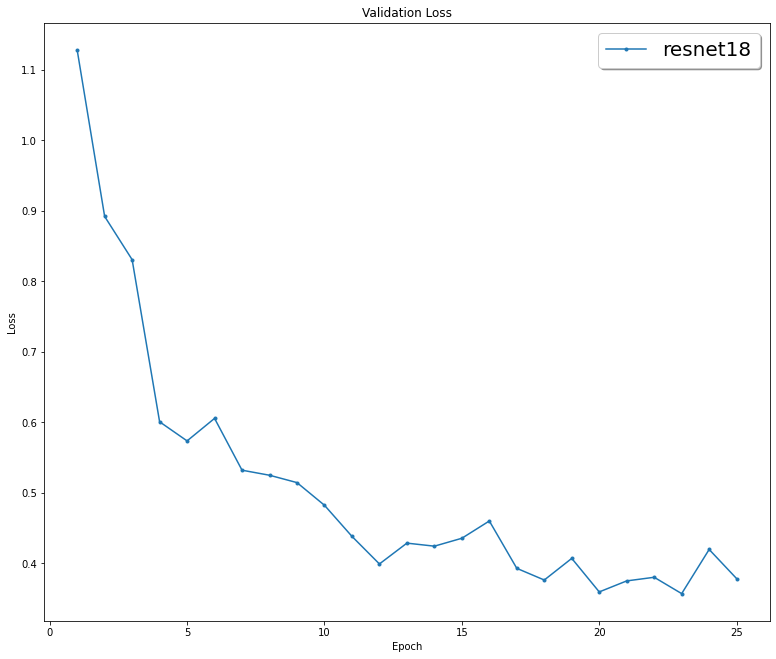

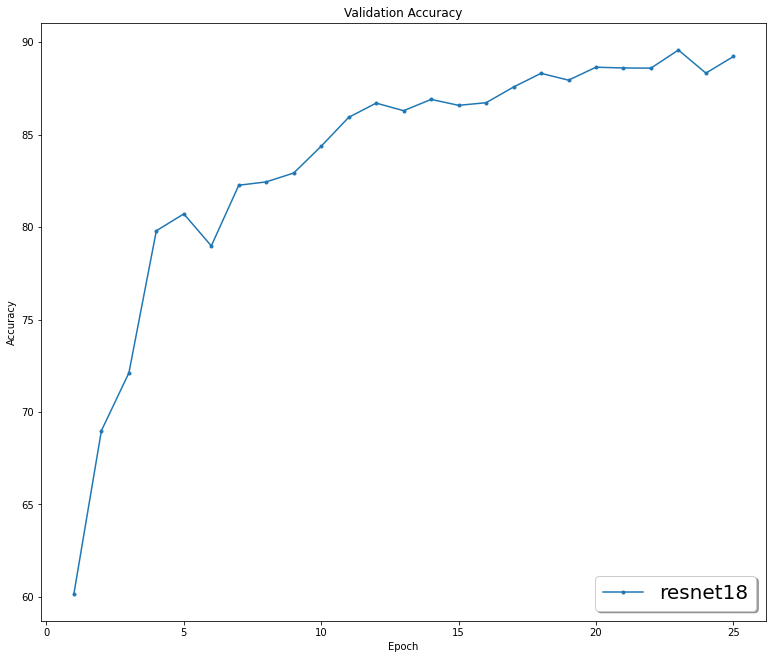

In [9]:
# Validation loss
losses = {}
accuracies = {}
for k, v in results.items():
    losses[k] = v['test_loss']
    accuracies[k] = v['test_acc']
  
plot_metric(losses, 'Loss')
plot_metric(accuracies, 'Accuracy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

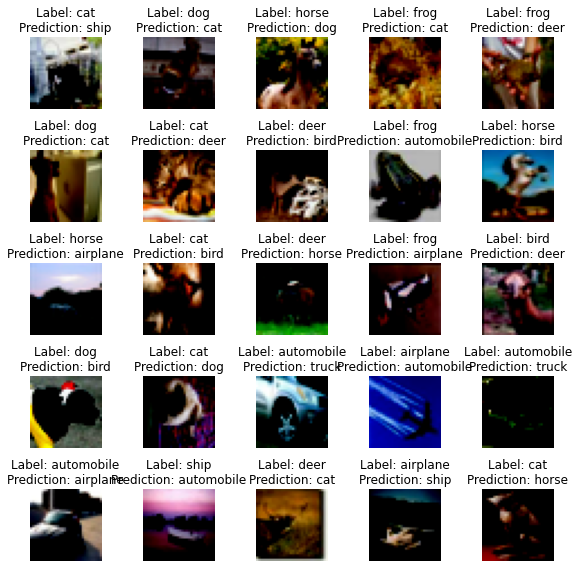

In [10]:
path_to_model = '/content/cifar10_model.pt'
incorrect_samples = identify_misclassification(ResNet18(), path_to_model, test_loader)

plot_results(incorrect_samples, cifar10.classes)


## Gradcam

For Gradcam use : 

1. Upload any picture of an airplane with name `airplane.jpg` directly in the colab and run the following cell.
2. Or you can edit the `image_path` argument accordingly with a valid image location.

In [11]:
# Plotting the gradcam for airplane 

plot_gradcam(image_path='/content/EVA5/S9/images/airplane.jpg', 
             model=model,
             layer='layer4.1.conv2',
             model_path='/content/cifar10_model.pt', 
             classes= cifar10.classes
             )


 #GRADCAM: airplane (prob : 0.9998502731323242)
	 Generating Image : gradcam-ResNet-layer4.1.conv2-airplane.png


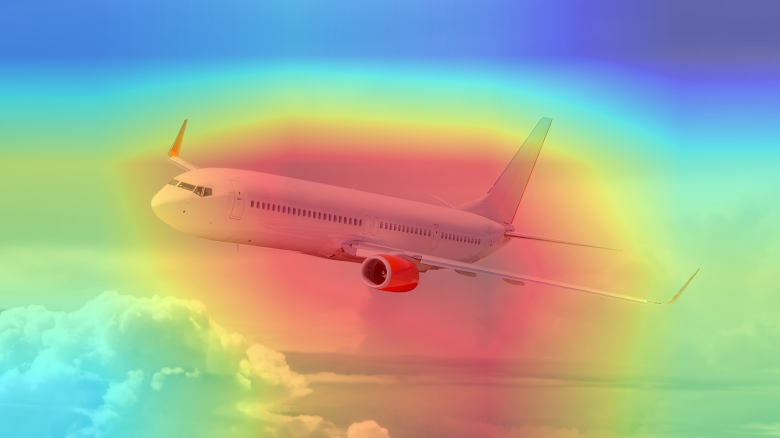

In [12]:
from IPython.display import Image
Image(filename='/content/gradcam-ResNet-layer4.1.conv2-airplane.png')